#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

For the output layer it was choosen the sigmoid activation function, as the track said, because this is a binary classification problem, and the sigmoid act funct return an output which is a prob value betwen 0 adn 1, perfect for the task (based on the threshold choosen we can either consider it a 0 or a 1).

For the loss it was choosen the binary cross entropy, since, still, is a binary classification problem

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [10]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 80s 400ms/step - loss: 0.6939 - accuracy: 0.5616 - val_loss: 0.6786 - val_accuracy: 0.5618
Epoch 2/10
196/196 [==============================] - 80s 406ms/step - loss: 0.5631 - accuracy: 0.7316 - val_loss: 0.5541 - val_accuracy: 0.7330
Epoch 3/10
196/196 [==============================] - 79s 405ms/step - loss: 0.3733 - accuracy: 0.8457 - val_loss: 0.4013 - val_accuracy: 0.8249
Epoch 4/10
196/196 [==============================] - 79s 404ms/step - loss: 0.2801 - accuracy: 0.8900 - val_loss: 0.3579 - val_accuracy: 0.8543
Epoch 5/10
196/196 [==============================] - 80s 408ms/step - loss: 0.2211 - accuracy: 0.9178 - val_loss: 0.3806 - val_accuracy: 0.8500
Epoch 6/10
196/196 [==============================] - 80s 407ms/step - loss: 0.1689 - accuracy: 0.9392 - val_loss: 0.3664 - val_accuracy: 0.8631
Epoch 7/10
196/196 [==============================] - 79s 402ms/step - loss: 0.1803 - accuracy: 0.9370 - val_loss: 0.5870 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 27s - loss: 0.4862 - accuracy: 0.8476
accuracy: 84.76%


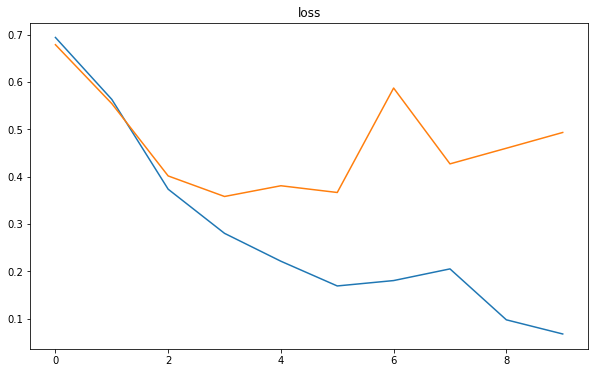

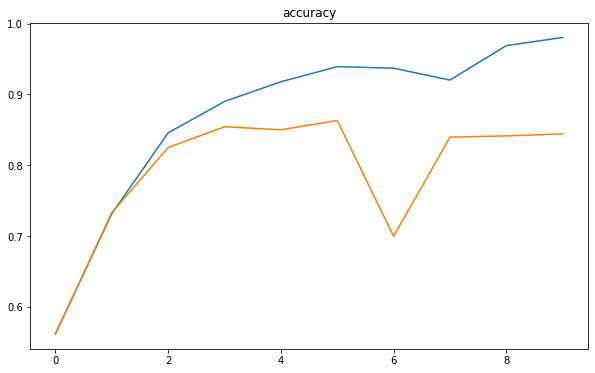

In [11]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

params of a SimpleRNN layer :  $units^2+units(input+1)=1376$.

params in LSTM layer :  4 * simpleRNN params -->  $4\cdot units(units+input+1)$.  ~14 layers to get the same number of params as SimpleRNN

params in a GRU layer :  $3\cdot units(units+input+2)$, 16 units close to params number of the other 2 models

In [12]:
np.random.seed(42)

model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(14))
model_lstm.add(keras.layers.Dense(1, activation="sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_lstm = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 9s 36ms/step - loss: 0.5579 - accuracy: 0.7306 - val_loss: 0.4160 - val_accuracy: 0.8359
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.3248 - accuracy: 0.8763 - val_loss: 0.3308 - val_accuracy: 0.8590
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 0.2366 - accuracy: 0.9129 - val_loss: 0.3120 - val_accuracy: 0.8648
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1882 - accuracy: 0.9352 - val_loss: 0.3122 - val_accuracy: 0.8718
Epoch 5/10
196/196 [==============================] - 6s 30ms/step - loss: 0.1573 - accuracy: 0.9475 - val_loss: 0.3213 - val_accuracy: 0.8681
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 0.1360 - accuracy: 0.9558 - val_loss: 0.3792 - val_accuracy: 0.8665
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1143 - accuracy: 0.9635 - val_loss: 0.3667 - val_accuracy: 0.8650

391/391 - 5s - loss: 0.4169 - accuracy: 0.8625
accuracy: 86.25%


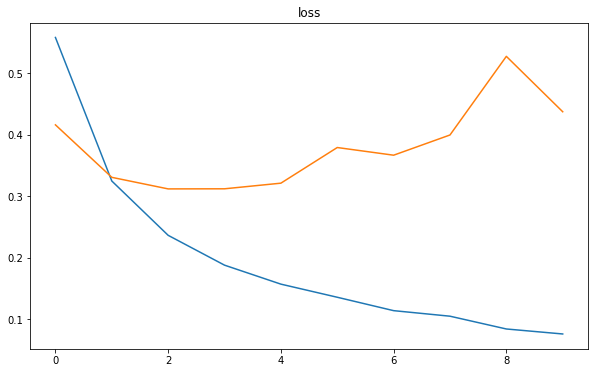

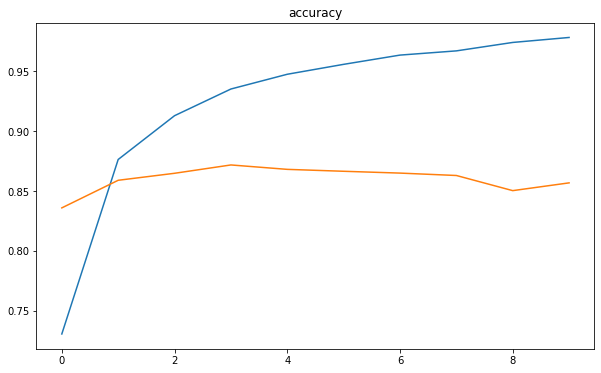

In [14]:
plot_loss(history_lstm)
plot_accuracy(history_lstm)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

In [15]:
np.random.seed(42)

model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(1, activation="sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_gru = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 7s 32ms/step - loss: 0.5796 - accuracy: 0.6740 - val_loss: 0.4239 - val_accuracy: 0.8034
Epoch 2/10
196/196 [==============================] - 6s 29ms/step - loss: 0.3026 - accuracy: 0.8771 - val_loss: 0.3239 - val_accuracy: 0.8677
Epoch 3/10
196/196 [==============================] - 6s 30ms/step - loss: 0.2242 - accuracy: 0.9164 - val_loss: 0.3260 - val_accuracy: 0.8662
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1853 - accuracy: 0.9338 - val_loss: 0.3575 - val_accuracy: 0.8653
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1566 - accuracy: 0.9473 - val_loss: 0.3580 - val_accuracy: 0.8633
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 0.1358 - accuracy: 0.9560 - val_loss: 0.3742 - val_accuracy: 0.8514
Epoch 7/10
196/196 [==============================] - 7s 33ms/step - loss: 0.1294 - accuracy: 0.9567 - val_loss: 0.4213 - val_accuracy: 0.8577

391/391 - 4s - loss: 0.4414 - accuracy: 0.8602
accuracy: 86.02%


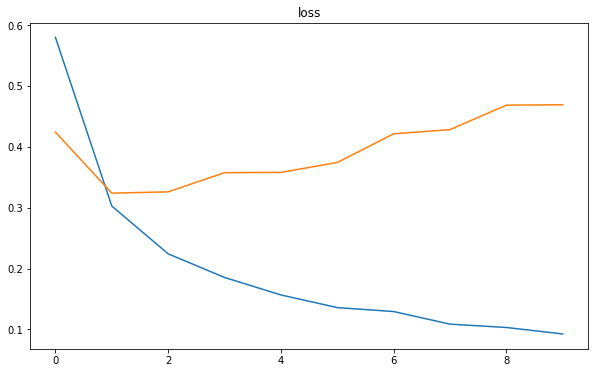

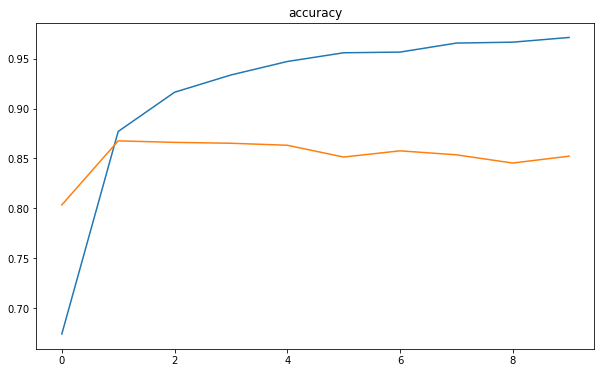

In [17]:
plot_loss(history_gru)
plot_accuracy(history_gru)

scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))

Using more or less the same number of parameter for the recurrent hidden unit the three models gain the same performances in temrs of accuracy and loss: in some runs one model performs slightly better than others, but in different runs they do so in turns, so there isn't a "winner".

In terms of time the simpleRNN one is the winner sinc eit takes about half time to be trained.

All the three models suffer of overfitting.

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [18]:
np.random.seed(42)

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 14s 60ms/step - loss: 0.5359 - accuracy: 0.7156 - val_loss: 0.3623 - val_accuracy: 0.8378
Epoch 2/5
196/196 [==============================] - 12s 59ms/step - loss: 0.2630 - accuracy: 0.8984 - val_loss: 0.2891 - val_accuracy: 0.8812
Epoch 3/5
196/196 [==============================] - 12s 61ms/step - loss: 0.2004 - accuracy

391/391 - 8s - loss: 0.3872 - accuracy: 0.8650
accuracy: 86.50%


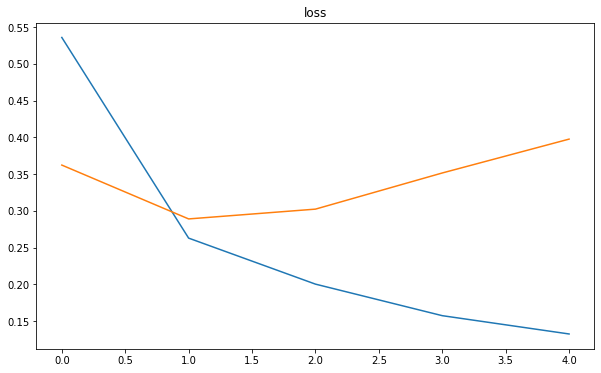

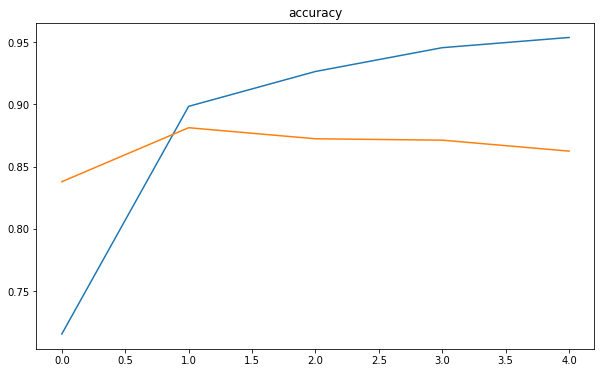

In [19]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

In [20]:
np.random.seed(42)

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 14s 61ms/step - loss: 0.6445 - accuracy: 0.6284 - val_loss: 0.4653 - val_accuracy: 0.7794
Epoch 2/5
196/196 [==============================] - 12s 59ms/step - loss: 0.4123 - accuracy: 0.8191 - 

391/391 - 8s - loss: 0.2672 - accuracy: 0.8910
accuracy: 89.10%


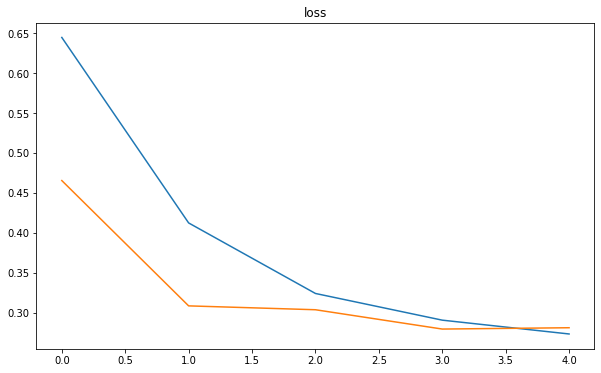

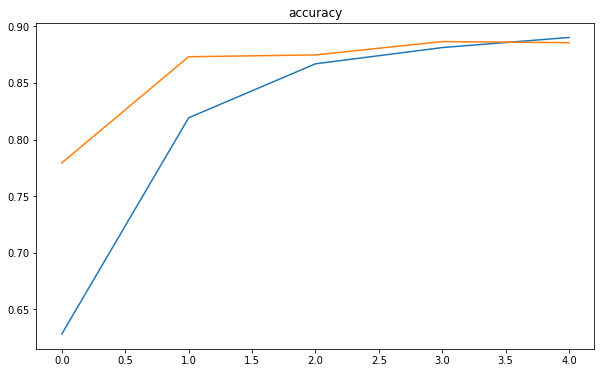

In [21]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

The dropuot layer mitigated the overfitting problem very weel, in any case we can try to further reduce overfitting by reducing the number of units of the recurrent hidden layer. This reduces the complexity of the model and so might prevent overfitting. A rule of thumb is to take a number between the input (10) of the layer and the output (1), so I choosed 5.

In [22]:
np.random.seed(42)

model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(5)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10)                640       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 100,651
Trainable params: 100,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 14s 59ms/step - loss: 0.6474 - accuracy: 0.6382 - val_loss: 0.5419 - val_accuracy: 0.7870
Epoch 2/5
196/196 [==============================] - 11s 57ms/step - loss: 0.5050 - accuracy: 0.8013 - 

391/391 - 8s - loss: 0.3598 - accuracy: 0.8551
accuracy: 85.51%


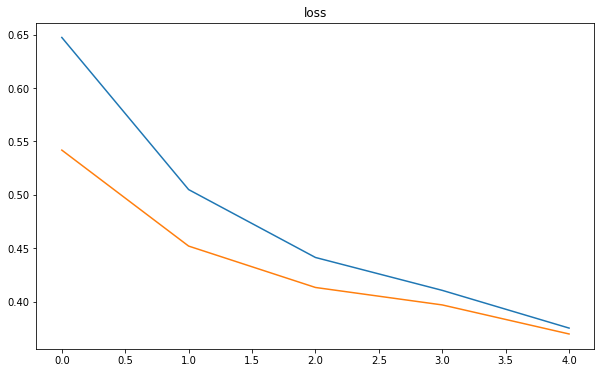

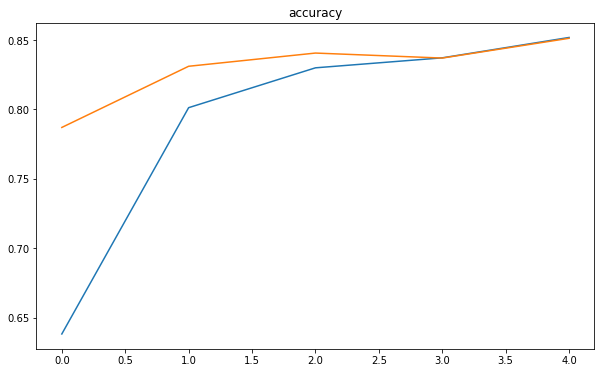

In [23]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))